reproducing Figure 9.2 (n-step semi-gradient TD)
alpha = 0.0 ... avg rms error = 0.5779
alpha = 0.1 ... avg rms error = 0.5078
alpha = 0.2 ... avg rms error = 0.4482
alpha = 0.3 ... avg rms error = 0.3944
alpha = 0.4 ... avg rms error = 0.3489
alpha = 0.5 ... avg rms error = 0.3075
alpha = 0.6 ... avg rms error = 0.2688
alpha = 0.7 ... avg rms error = 0.2455
alpha = 0.8 ... avg rms error = 0.2318
alpha = 0.9 ... avg rms error = 0.2575
alpha = 1.0 ... avg rms error = 0.4174


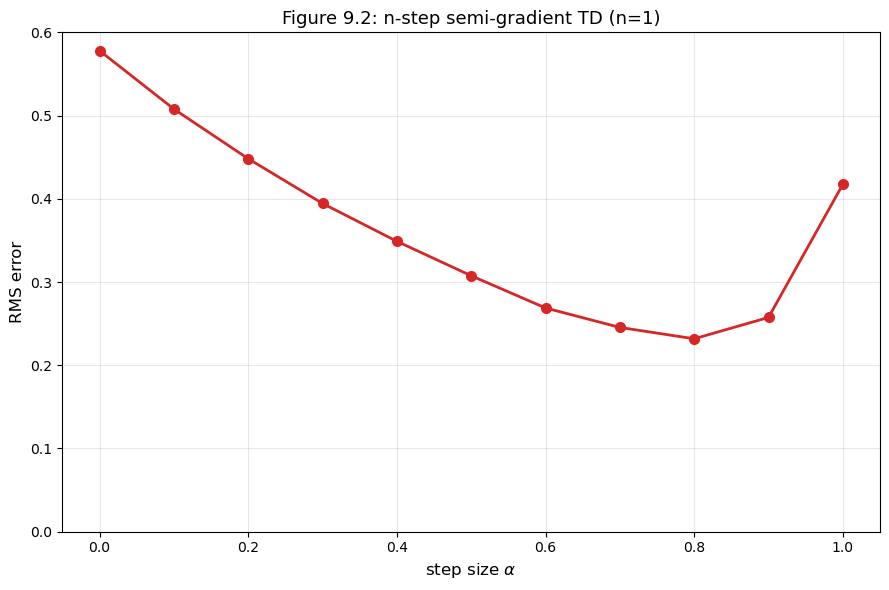

In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# environment: 1000-state random walk
# ============================================================================

class RandomWalk1000:
    """1000-state random walk task from Sutton Barto Chapter 9"""
    
    def __init__(self):
        self.start = 500
        self.reset()
    
    def reset(self):
        self.state = self.start
        return self.state
    
    def is_terminal(self):
        return self.state <= 0 or self.state >= 1001
    
    def step(self, action=None):
        step_size = np.random.randint(1, 101)
        direction = np.random.choice([-1, 1])
        
        self.state += direction * step_size
        
        if self.state <= 0:
            return 0, -1.0
        elif self.state >= 1001:
            return 1001, 1.0
        else:
            return self.state, 0.0


# ============================================================================
# agent: semi-gradient n-step TD with linear function approximation
# ============================================================================

class TD_Agent:
    """n-step semi-gradient TD learner using state aggregation"""
    
    def __init__(self, num_weights, alpha, n_step):
        self.w = np.zeros(num_weights)
        self.alpha = alpha
        self.n_step = n_step
        self.num_groups = num_weights
        self.group_size = 1000 // num_weights
    
    def get_group(self, state):
        if state <= 0 or state >= 1001:
            return None
        return (state - 1) // self.group_size
    
    def estimate(self, state):
        group = self.get_group(state)
        if group is None:
            return 0.0
        return self.w[group]
    
    def learn_episode(self, env):
        state = env.reset()
        trajectory = [state]
        rewards = []
        
        while not env.is_terminal():
            next_state, reward = env.step()
            trajectory.append(next_state)
            rewards.append(reward)
            state = next_state
        
        trajectory.append(env.state)
        episode_length = len(rewards)
        
        for t in range(episode_length):
            G = 0.0
            
            for i in range(t, min(t + self.n_step, episode_length)):
                G += rewards[i]
            
            if t + self.n_step < episode_length:
                next_state = trajectory[t + self.n_step]
                G += self.estimate(next_state)
            
            state_t = trajectory[t]
            current_estimate = self.estimate(state_t)
            error = G - current_estimate
            
            group = self.get_group(state_t)
            if group is not None:
                self.w[group] += self.alpha * error


# ============================================================================
# utility functions
# ============================================================================

def compute_true_values():
    v = np.zeros(1002)
    for s in range(1, 1001):
        v[s] = -1.0 + (s - 1) * (2.0 / 999.0)
    return v

def rms_error(agent, true_v):
    estimates = np.array([agent.estimate(s) for s in range(1, 1001)])
    targets = true_v[1:1001]
    mse = np.mean((estimates - targets) ** 2)
    return np.sqrt(mse)


# ============================================================================
# run experiment
# ============================================================================

print("reproducing Figure 9.2 (n-step semi-gradient TD)")
print("=" * 60)

alphas = np.linspace(0.0, 1.0, 11)
n_step = 1
num_groups = 20
num_runs = 100
num_episodes = 10

true_v = compute_true_values()
results = []

for alpha in alphas:
    print(f"alpha = {alpha:.1f}", end=" ... ")
    
    total_error = 0.0
    
    for run in range(num_runs):
        agent = TD_Agent(num_groups, alpha, n_step)
        env = RandomWalk1000()
        
        for ep in range(num_episodes):
            agent.learn_episode(env)
        
        error = rms_error(agent, true_v)
        total_error += error
    
    avg_error = total_error / num_runs
    results.append(avg_error)
    print(f"avg rms error = {avg_error:.4f}")

print("=" * 60)

# plot results
plt.figure(figsize=(9, 6))
plt.plot(alphas, results, 'o-', linewidth=2, markersize=7, color='#d62728')
plt.xlabel(r'step size $\alpha$', fontsize=12)
plt.ylabel('RMS error', fontsize=12)
plt.title('Figure 9.2: n-step semi-gradient TD (n=1)', fontsize=13)
plt.grid(True, alpha=0.3)
plt.ylim(0.0, 0.6)
plt.tight_layout()
plt.show()


reproducing Figure 9.1 (Gradient Monte Carlo)
episode  25000: rms error = 0.1645
episode  50000: rms error = 0.0954
episode  75000: rms error = 0.0774
episode 100000: rms error = 0.0748


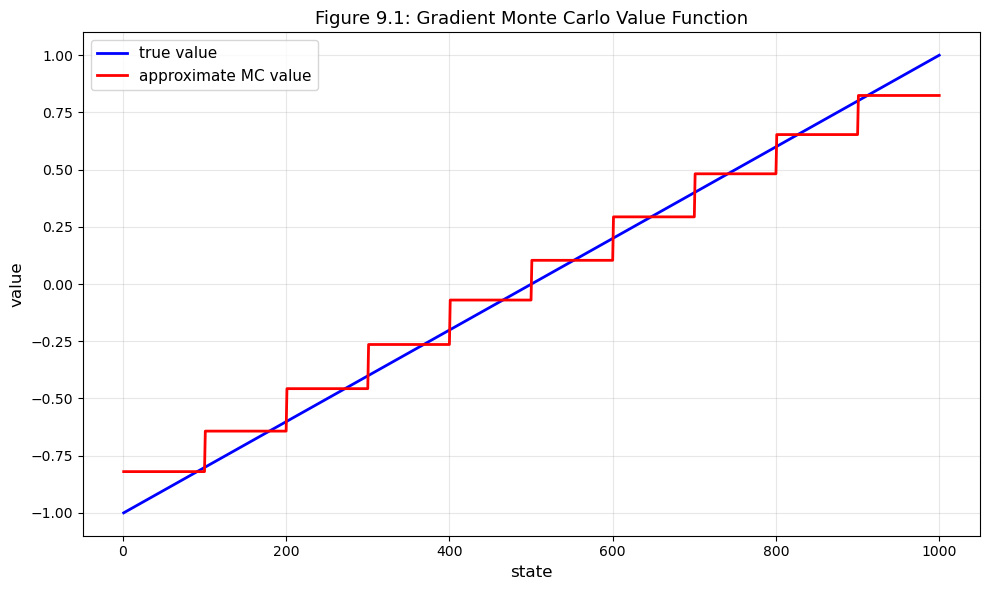


learning complete!


In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# environment: 1000-state random walk
# ============================================================================

class RandomWalk1000:
    """1000-state random walk task from Sutton Barto Chapter 9"""
    
    def __init__(self):
        self.start = 500
        self.reset()
    
    def reset(self):
        self.state = self.start
        return self.state
    
    def is_terminal(self):
        return self.state <= 0 or self.state >= 1001
    
    def step(self, action=None):
        step_size = np.random.randint(1, 101)
        direction = np.random.choice([-1, 1])
        
        self.state += direction * step_size
        
        if self.state <= 0:
            return 0, -1.0
        elif self.state >= 1001:
            return 1001, 1.0
        else:
            return self.state, 0.0


# ============================================================================
# agent: gradient monte carlo (constant-alpha, unbiased MC)
# ============================================================================

class MC_Agent:
    """gradient monte carlo learner using state aggregation"""
    
    def __init__(self, num_weights, alpha):
        self.w = np.zeros(num_weights)
        self.alpha = alpha
        self.num_groups = num_weights
        self.group_size = 1000 // num_weights
    
    def get_group(self, state):
        if state <= 0 or state >= 1001:
            return None
        return (state - 1) // self.group_size
    
    def estimate(self, state):
        group = self.get_group(state)
        if group is None:
            return 0.0
        return self.w[group]
    
    def learn_episode(self, env):
        """run one episode and update using MC return (G = actual cumulative reward)"""
        state = env.reset()
        trajectory = [state]
        rewards = []
        
        # collect full episode
        while not env.is_terminal():
            next_state, reward = env.step()
            trajectory.append(next_state)
            rewards.append(reward)
            state = next_state
        
        # compute MC return (G = sum of all rewards from start)
        # with gamma=1, this is just the total reward
        G = sum(rewards)
        
        # update each state in trajectory toward the same return G
        # gradient MC: all states get the same target (the episode return)
        for state_t in trajectory[:-1]:  # exclude terminal state
            current_estimate = self.estimate(state_t)
            error = G - current_estimate
            
            group = self.get_group(state_t)
            if group is not None:
                self.w[group] += self.alpha * error


# ============================================================================
# utility functions
# ============================================================================

def compute_true_values():
    v = np.zeros(1002)
    for s in range(1, 1001):
        v[s] = -1.0 + (s - 1) * (2.0 / 999.0)
    return v

def rms_error(agent, true_v):
    estimates = np.array([agent.estimate(s) for s in range(1, 1001)])
    targets = true_v[1:1001]
    mse = np.mean((estimates - targets) ** 2)
    return np.sqrt(mse)


# ============================================================================
# run experiment: Figure 9.1
# ============================================================================

print("reproducing Figure 9.1 (Gradient Monte Carlo)")
print("=" * 60)

alpha = 2e-5  # small step size for stability
num_groups = 10  # 10 groups of 100 states each
num_episodes = 100000

true_v = compute_true_values()
agent = MC_Agent(num_groups, alpha)
env = RandomWalk1000()

# run many episodes
for ep in range(num_episodes):
    agent.learn_episode(env)
    
    if (ep + 1) % 25000 == 0:
        error = rms_error(agent, true_v)
        print(f"episode {ep + 1:6d}: rms error = {error:.4f}")

print("=" * 60)

# get final learned values
learned_values = np.array([agent.estimate(s) for s in range(1, 1001)])
true_values_plot = true_v[1:1001]

# plot: learned vs true values
plt.figure(figsize=(10, 6))
plt.plot(range(1, 1001), true_values_plot, label='true value', linewidth=2, color='blue')
plt.plot(range(1, 1001), learned_values, label='approximate MC value', linewidth=2, color='red')
plt.xlabel('state', fontsize=12)
plt.ylabel('value', fontsize=12)
plt.title('Figure 9.1: Gradient Monte Carlo Value Function', fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nlearning complete!")